In [74]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [2]:
external_data = pd.read_csv("data/external_data.csv")

In [3]:
external_data.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


In [4]:
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   numer_sta  3322 non-null   int64  
 1   date       3322 non-null   object 
 2   pmer       3322 non-null   int64  
 3   tend       3322 non-null   int64  
 4   cod_tend   3322 non-null   int64  
 5   dd         3322 non-null   int64  
 6   ff         3322 non-null   float64
 7   t          3322 non-null   float64
 8   td         3322 non-null   float64
 9   u          3322 non-null   int64  
 10  vv         3322 non-null   int64  
 11  ww         3322 non-null   int64  
 12  w1         3315 non-null   float64
 13  w2         3312 non-null   float64
 14  n          3166 non-null   float64
 15  nbas       3317 non-null   float64
 16  hbas       2869 non-null   float64
 17  cl         2909 non-null   float64
 18  cm         1941 non-null   float64
 19  ch         1678 non-null   float64
 20  pres    

In [5]:
external_data["date"] = pd.to_datetime(external_data["date"])

In [6]:
external_data = external_data.dropna(axis=1, how="all")

In [7]:
threshold = 0.8  # drop columns with 80% missing values
external_data = external_data.dropna(thresh=threshold * len(external_data), axis=1)

In [8]:
external_data = external_data.fillna(external_data.mean())

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\3005236704.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  external_data = external_data.fillna(external_data.mean())


In [9]:
print(external_data.describe())

       numer_sta           pmer         tend     cod_tend           dd  \
count     3322.0    3322.000000  3322.000000  3322.000000  3322.000000   
mean      7149.0  101682.886815    -0.237809     4.273028   184.379892   
std          0.0     923.888170   122.191314     2.713199   103.708084   
min       7149.0   97260.000000  -750.000000     0.000000     0.000000   
25%       7149.0  101200.000000   -70.000000     2.000000    80.000000   
50%       7149.0  101820.000000     0.000000     3.000000   200.000000   
75%       7149.0  102287.500000    70.000000     7.000000   260.000000   
max       7149.0  103920.000000   720.000000     8.000000   360.000000   

                ff            t           td            u            vv  ...  \
count  3322.000000  3322.000000  3322.000000  3322.000000   3322.000000  ...   
mean      3.654154   285.877905   281.006442    74.775135  20142.338952  ...   
std       2.000353     6.851700     5.634409    17.022427  10283.556918  ...   
min       0.0

In [10]:
external_data = external_data.drop("numer_sta", axis=1)

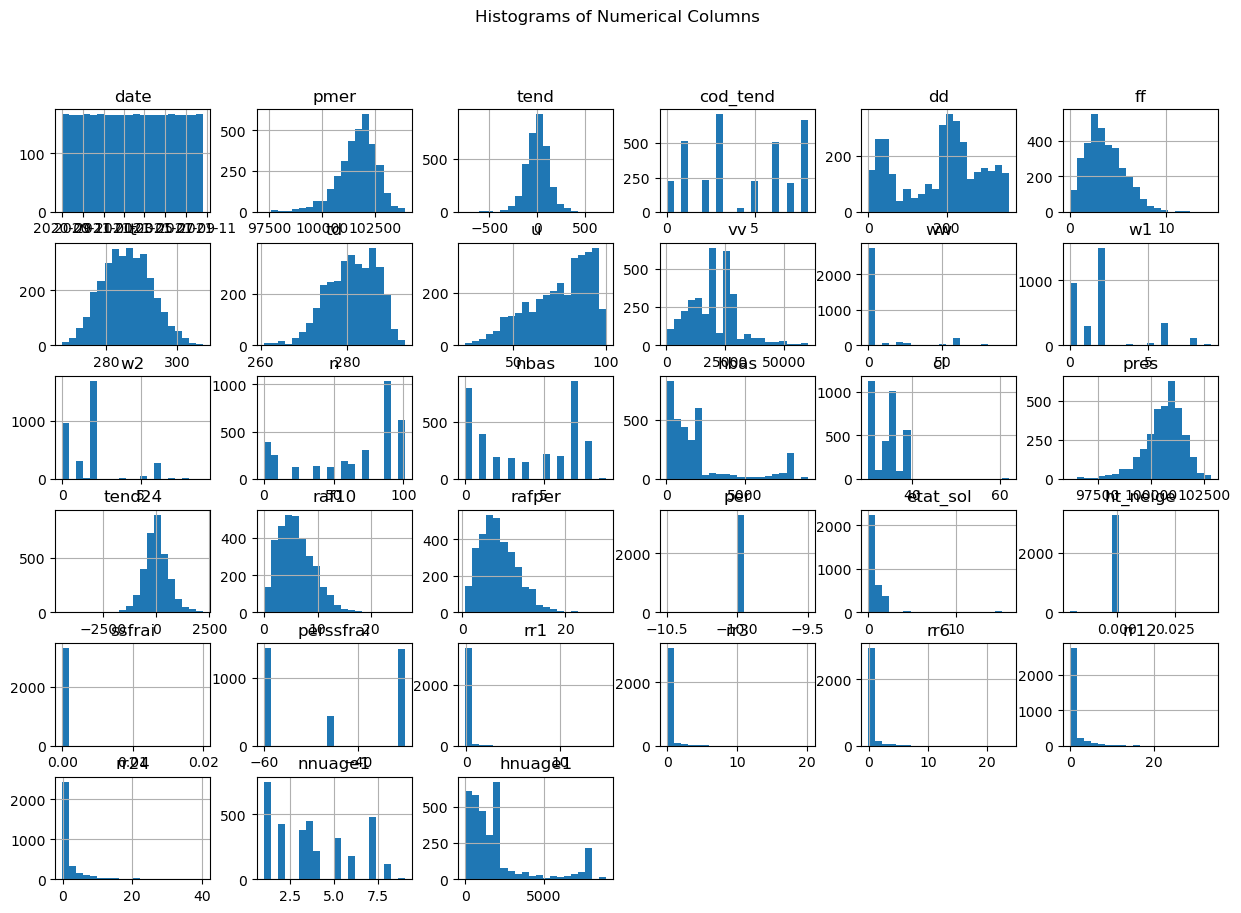

In [11]:
external_data.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\241235050.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = external_data.corr()


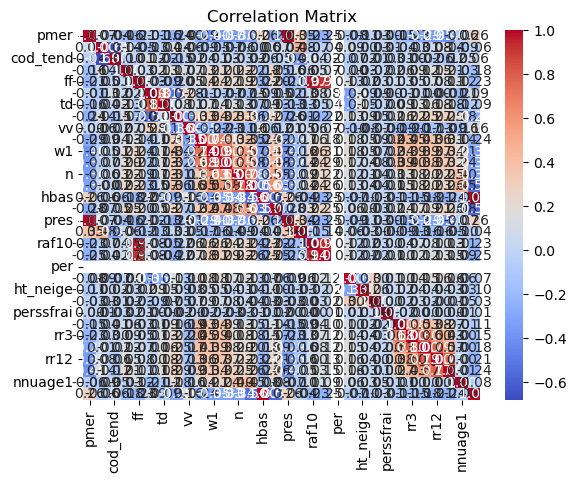

In [12]:
correlation_matrix = external_data.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [13]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [15]:
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3322 non-null   datetime64[ns]
 1   pmer       3322 non-null   int64         
 2   tend       3322 non-null   int64         
 3   cod_tend   3322 non-null   int64         
 4   dd         3322 non-null   int64         
 5   ff         3322 non-null   float64       
 6   t          3322 non-null   float64       
 7   td         3322 non-null   float64       
 8   u          3322 non-null   int64         
 9   vv         3322 non-null   int64         
 10  ww         3322 non-null   int64         
 11  w1         3322 non-null   float64       
 12  w2         3322 non-null   float64       
 13  n          3322 non-null   float64       
 14  nbas       3322 non-null   float64       
 15  hbas       3322 non-null   float64       
 16  cl         3322 non-null   float64       


In [16]:
# Sort both 'data' and 'external_data' dataframes by the 'date' column
data_sorted = data.sort_values(by="date")
external_data_sorted = external_data.sort_values(by="date")

# Assuming you want to merge based on a 1-hour time difference
merged_data = pd.merge_asof(
    data_sorted,
    external_data_sorted,
    on="date",
    direction="backward",
    tolerance=pd.Timedelta("6H"),
)

In [17]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
 11  pmer                       455163 non-null  int64   

Cyclist Data Columns:

counter_id, counter_name, site_id, site_name, bike_count, date, counter_installation_date, counter_technical_id, latitude, longitude, log_bike_count.

Weather Data Columns:

pmer, tend, cod_tend, dd, ff, t, td, u, vv, ww, w1, w2, n, nbas, hbas, cl, pres, tend24, raf10, rafper, per, etat_sol, ht_neige, ssfrai, perssfrai, rr1, rr3, rr6, rr12, rr24, nnuage1, hnuage1.

In [18]:
# Drop the 'bike_count' column from the feature set
feature_set = merged_data.drop("bike_count", axis=1)

# Display the updated feature set
print(feature_set.head())

            counter_id                     counter_name    site_id  \
0  100056332-104056332              Pont de Bercy SO-NE  100056332   
1  100047547-104047547         6 rue Julia Bartet NE-SO  100047547   
2  100047547-103047547         6 rue Julia Bartet SO-NE  100047547   
3  100057380-103057380         Totem Cours la Reine O-E  100057380   
4  100047548-103047548  Face au 25 quai de l'Oise NE-SO  100047548   

                   site_name                date counter_installation_date  \
0              Pont de Bercy 2020-09-01 01:00:00                2019-12-11   
1         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
2         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
3       Totem Cours la Reine 2020-09-01 01:00:00                2020-02-11   
4  Face au 25 quai de l'Oise 2020-09-01 01:00:00                2018-11-28   

  counter_technical_id  latitude  longitude  log_bike_count  ...  ht_neige  \
0          Y2H19070378  48.83848

In [19]:
# Convert the 'date' column to datetime objects
feature_set["date"] = pd.to_datetime(feature_set["date"])

# Extract datetime features
feature_set["day_of_week"] = feature_set["date"].dt.dayofweek
feature_set["month"] = feature_set["date"].dt.month
feature_set["hour"] = feature_set["date"].dt.hour

# Display the updated feature set
print(feature_set.head())

            counter_id                     counter_name    site_id  \
0  100056332-104056332              Pont de Bercy SO-NE  100056332   
1  100047547-104047547         6 rue Julia Bartet NE-SO  100047547   
2  100047547-103047547         6 rue Julia Bartet SO-NE  100047547   
3  100057380-103057380         Totem Cours la Reine O-E  100057380   
4  100047548-103047548  Face au 25 quai de l'Oise NE-SO  100047548   

                   site_name                date counter_installation_date  \
0              Pont de Bercy 2020-09-01 01:00:00                2019-12-11   
1         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
2         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
3       Totem Cours la Reine 2020-09-01 01:00:00                2020-02-11   
4  Face au 25 quai de l'Oise 2020-09-01 01:00:00                2018-11-28   

  counter_technical_id  latitude  longitude  log_bike_count  ...  rr1  rr3  \
0          Y2H19070378  48.83848

In [20]:
lag_variables = ["pmer", "t", "ff", "u", "pres", "raf10", "rr1"]

In [21]:
for variable in lag_variables:
    for i in range(1, 4):  # Create lag features for the past 3 hours
        feature_set[f"{variable}_lag_{i}"] = feature_set[variable].shift(i)

In [22]:
feature_set["wind_x"] = feature_set["ff"] * np.cos(np.radians(feature_set["dd"]))
feature_set["wind_y"] = feature_set["ff"] * np.sin(np.radians(feature_set["dd"]))

# Display the updated feature_set
print(feature_set.head())

            counter_id                     counter_name    site_id  \
0  100056332-104056332              Pont de Bercy SO-NE  100056332   
1  100047547-104047547         6 rue Julia Bartet NE-SO  100047547   
2  100047547-103047547         6 rue Julia Bartet SO-NE  100047547   
3  100057380-103057380         Totem Cours la Reine O-E  100057380   
4  100047548-103047548  Face au 25 quai de l'Oise NE-SO  100047548   

                   site_name                date counter_installation_date  \
0              Pont de Bercy 2020-09-01 01:00:00                2019-12-11   
1         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
2         6 rue Julia Bartet 2020-09-01 01:00:00                2018-11-28   
3       Totem Cours la Reine 2020-09-01 01:00:00                2020-02-11   
4  Face au 25 quai de l'Oise 2020-09-01 01:00:00                2018-11-28   

  counter_technical_id  latitude  longitude  log_bike_count  ...  pres_lag_2  \
0          Y2H19070378  48.838

In [23]:
feature_set["temp_humidity_interaction"] = feature_set["t"] * feature_set["u"]

In [24]:
feature_set["temp_lag_1"] = feature_set["t"].shift(1)

In [25]:
feature_set["cloud_wind_interaction"] = feature_set["cl"] * feature_set["ff"]

In [26]:
feature_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 71 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   date                       455163 non-null  datetime64[ns]
 5   counter_installation_date  455163 non-null  datetime64[ns]
 6   counter_technical_id       455163 non-null  category      
 7   latitude                   455163 non-null  float64       
 8   longitude                  455163 non-null  float64       
 9   log_bike_count             455163 non-null  float64       
 10  pmer                       455163 non-null  int64         
 11  tend                       455163 non-null  int64   

In [27]:
# Create lag features for precipitation using precipitation over 1 hour
feature_set["precipitation_lag_1"] = feature_set["rr1"].shift(1)
feature_set["precipitation_lag_2"] = feature_set["rr1"].shift(2)

# Explore interactions with other weather variables
feature_set["interaction_precipitation_temperature"] = (
    feature_set["rr1"] * feature_set["t"]
)

In [28]:
# Calculate the age of the bike counter since installation
feature_set["counter_age"] = (
    feature_set["date"] - feature_set["counter_installation_date"]
).dt.days

In [29]:
feature_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 75 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   counter_id                             455163 non-null  category      
 1   counter_name                           455163 non-null  category      
 2   site_id                                455163 non-null  int64         
 3   site_name                              455163 non-null  category      
 4   date                                   455163 non-null  datetime64[ns]
 5   counter_installation_date              455163 non-null  datetime64[ns]
 6   counter_technical_id                   455163 non-null  category      
 7   latitude                               455163 non-null  float64       
 8   longitude                              455163 non-null  float64       
 9   log_bike_count                         455163 no

In [30]:
# Drop rows with NaN values
feature_set_cleaned = feature_set.dropna()

# Verify the result
feature_set_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455160 entries, 3 to 455162
Data columns (total 75 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   counter_id                             455160 non-null  category      
 1   counter_name                           455160 non-null  category      
 2   site_id                                455160 non-null  int64         
 3   site_name                              455160 non-null  category      
 4   date                                   455160 non-null  datetime64[ns]
 5   counter_installation_date              455160 non-null  datetime64[ns]
 6   counter_technical_id                   455160 non-null  category      
 7   latitude                               455160 non-null  float64       
 8   longitude                              455160 non-null  float64       
 9   log_bike_count                         455160 no

In [31]:
print("Unique counts:")
print("counter_id:", feature_set_cleaned["counter_id"].nunique())
print("counter_name:", feature_set_cleaned["counter_name"].nunique())
print("site_id:", feature_set_cleaned["site_id"].nunique())
print("site_name:", feature_set_cleaned["site_name"].nunique())
print("counter_technical_id:", feature_set_cleaned["counter_technical_id"].nunique())

Unique counts:
counter_id: 56
counter_name: 56
site_id: 30
site_name: 30
counter_technical_id: 30


In [ ]:
# velib = pd.read_csv("data/station-velib.csv", sep=";")

In [ ]:
# velib["geo_point_2d"] = velib["geo_point_2d"].str.split(",")
# velib["latitude"] = velib["geo_point_2d"].apply(lambda x: float(x[0]))
# velib["longitude"] = velib["geo_point_2d"].apply(lambda x: float(x[1]))

In [ ]:
# velib.to_csv("data/velib_cleaned.csv", index=False)

In [32]:
velib = pd.read_csv("data/velib_cleaned.csv")

In [33]:
velib_stations = list(zip(velib["latitude"], velib["longitude"]))

In [34]:
from scipy.spatial import cKDTree

In [35]:
feature_set_coords = feature_set_cleaned[["latitude", "longitude"]]

In [36]:
velib["latitude"] = pd.to_numeric(velib["latitude"])
velib["longitude"] = pd.to_numeric(velib["longitude"])

In [37]:
velib_tree = cKDTree(velib[["latitude", "longitude"]].values)

In [38]:
distances, indices = velib_tree.query(feature_set_coords, k=1)

In [39]:
feature_set_cleaned["distance_to_nearest_velib"] = distances

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\3180311223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set_cleaned["distance_to_nearest_velib"] = distances


In [40]:
feature_set_cleaned.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,...,wind_x,wind_y,temp_humidity_interaction,temp_lag_1,cloud_wind_interaction,precipitation_lag_1,precipitation_lag_2,interaction_precipitation_temperature,counter_age,distance_to_nearest_velib
3,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2020-09-01 01:00:00,2020-02-11,YTH19111509,48.86462,2.31444,0.000000,...,1.503508,-0.547232,23145.75,285.75,48.0,0.0,0.0,0.0,203,0.045046
4,100047548-103047548,Face au 25 quai de l'Oise NE-SO,100047548,Face au 25 quai de l'Oise,2020-09-01 01:00:00,2018-11-28,Y2H18086324,48.89141,2.38482,1.098612,...,1.503508,-0.547232,23145.75,285.75,48.0,0.0,0.0,0.0,643,0.111522
5,100047548-104047548,Face au 25 quai de l'Oise SO-NE,100047548,Face au 25 quai de l'Oise,2020-09-01 01:00:00,2018-11-28,Y2H18086324,48.89141,2.38482,0.000000,...,1.503508,-0.547232,23145.75,285.75,48.0,0.0,0.0,0.0,643,0.111522
6,100057380-104057380,Totem Cours la Reine E-O,100057380,Totem Cours la Reine,2020-09-01 01:00:00,2020-02-11,YTH19111509,48.86462,2.31444,1.098612,...,1.503508,-0.547232,23145.75,285.75,48.0,0.0,0.0,0.0,203,0.045046
7,100057445-103057445,Totem 73 boulevard de Sébastopol N-S,100057445,Totem 73 boulevard de Sébastopol,2020-09-01 01:00:00,2020-02-11,YTH19111510,48.86377,2.35096,1.098612,...,1.503508,-0.547232,23145.75,285.75,48.0,0.0,0.0,0.0,203,0.067840


In [41]:
feature_set_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455160 entries, 3 to 455162
Data columns (total 76 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   counter_id                             455160 non-null  category      
 1   counter_name                           455160 non-null  category      
 2   site_id                                455160 non-null  int64         
 3   site_name                              455160 non-null  category      
 4   date                                   455160 non-null  datetime64[ns]
 5   counter_installation_date              455160 non-null  datetime64[ns]
 6   counter_technical_id                   455160 non-null  category      
 7   latitude                               455160 non-null  float64       
 8   longitude                              455160 non-null  float64       
 9   log_bike_count                         455160 no

In [42]:
feature_set_cleaned["year"] = feature_set_cleaned["date"].dt.year

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\3849795469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set_cleaned["year"] = feature_set_cleaned["date"].dt.year


In [52]:
numerical_features = [
    "latitude",
    "longitude",
    "pmer",
    "tend",
    "t",
    "td",
    "u",
    "vv",
    "n",
    "nbas",
    "hbas",
    "pres",
    "tend24",
    "raf10",
    "rafper",
    "ht_neige",
    "ssfrai",
    "rr1",
    "rr3",
    "rr6",
    "rr12",
    "rr24",
    "pmer_lag_1",
    "pmer_lag_2",
    "pmer_lag_3",
    "t_lag_1",
    "t_lag_2",
    "t_lag_3",
    "ff_lag_1",
    "ff_lag_2",
    "ff_lag_3",
    "u_lag_1",
    "u_lag_2",
    "u_lag_3",
    "pres_lag_1",
    "pres_lag_2",
    "pres_lag_3",
    "raf10_lag_1",
    "raf10_lag_2",
    "raf10_lag_3",
    "rr1_lag_1",
    "rr1_lag_2",
    "rr1_lag_3",
    "wind_x",
    "wind_y",
    "temp_humidity_interaction",
    "temp_lag_1",
    "cloud_wind_interaction",
    "precipitation_lag_1",
    "precipitation_lag_2",
    "interaction_precipitation_temperature",
    "counter_age",
    "distance_to_nearest_velib",
]

In [53]:
categorical_features = [
    "counter_name",
    "site_name",
    "counter_technical_id",
    "cod_tend",
    "ww",
    "etat_sol",
    "day_of_week",
    "month",
    "hour",
    "year",
]

selected_features = numerical_features + categorical_features + ["log_bike_count"]

In [54]:
df_final = feature_set_cleaned[selected_features].copy()

In [51]:
# numerical_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [52]:
# preprocessor = ColumnTransformer(
#    transformers=[
#        ("num", numerical_transformer, numerical_features),
#        ("cat", categorical_transformer, categorical_features),
#    ]
# )

In [ ]:
# model = RandomForestRegressor(n_jobs=-1)

In [ ]:
# pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

In [ ]:
# df_final_subset = df_final.sample(frac=0.1, random_state=42)

In [ ]:
# X = df_final_subset.drop("log_bike_count", axis=1)
# y = df_final_subset["log_bike_count"]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42
# )

In [ ]:
# print(f"Train: n_samples={X_train.shape[0]}")
# print(f"Test: n_samples={X_test.shape[0]}")

In [ ]:
# pipeline.fit(X_train, y_train)

In [ ]:
# y_pred = pipeline.predict(X_test)

# Calculate RMSE
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("Root Mean Squared Error:", rmse)

In [ ]:
# rf_model = pipeline.named_steps["model"]

In [ ]:
# Get feature importances
# feature_importances = rf_model.feature_importances_

In [49]:
"""
feature_importance_df = pd.DataFrame(


    {


        "Feature": numerical_features


        + list(


            pipeline.named_steps["preprocessor"]


            .named_transformers_["cat"]


            .get_feature_names_out(categorical_features)


        ),


        "Importance": feature_importances,


    }


)
"""

'\nfeature_importance_df = pd.DataFrame(\n\n    {\n\n        "Feature": numerical_features\n\n        + list(\n\n            pipeline.named_steps["preprocessor"]\n\n            .named_transformers_["cat"]\n\n            .get_feature_names_out(categorical_features)\n\n        ),\n\n        "Importance": feature_importances,\n\n    }\n\n)\n'

In [ ]:
# feature_importance_df = feature_importance_df.sort_values(
#    by="Importance", ascending=False
# )

In [ ]:
# print(feature_importance_df)

In [ ]:
# Save feature importances to a CSV file
# feature_importance_df.to_csv("feature_importance.csv", index=False)

features to keep:
1. hour- categorical
2. counter age- numerical
3. counter name- categorical
4. counter_technical_id- categorical
5. site_name- categorical
6. day_of_week- categorical
7. t- numerical
8. t_lag 1 to 3- numerical
9. tend24- numerical
10. distance_to_nearest_velib- numerical
11. td- numerical
12. temp_humidity_interaction- numerical
13. wind_x- numerical
14. wind_y- numerical
15. tend- numerical
16. u_lag 1 to 3- numerical
17. hbas- numerical
18. u- numerical
19. rr24- numerical
20. rafper- numerical
21. n- numerical
22. cloud_wind_interaction- numerical
23. nbas- numerical
24. rr12- numerical
25. etat_sol- categorical
26. rr6- numerical
27. pres- numerical
28. pres_lag 1 to 3- numerical
29. raf10_lag 1 to 3- numerical
30. ff_lag 1 to 3- numerical
31. pmer- numerical
32. pmer lag 1 to 3- numerical
33. rr3- numerical
34. raf10- numerical

In [99]:
# Updated numerical and categorical features for XGBoost
numerical_features_xgb = [
    "counter_age",
    "t",
    "t_lag_1",
    "t_lag_2",
    "t_lag_3",
    "tend24",
    "distance_to_nearest_velib",
    "td",
    "temp_humidity_interaction",
    "wind_x",
    "wind_y",
    "tend",
    "u_lag_1",
    "u_lag_2",
    "u_lag_3",
    "hbas",
    "u",
    "rr24",
    "rafper",
    "n",
    "cloud_wind_interaction",
    "nbas",
    "rr12",
    "rr6",
    "pres",
    "pres_lag_1",
    "pres_lag_2",
    "pres_lag_3",
    "raf10_lag_1",
    "raf10_lag_2",
    "raf10_lag_3",
    "ff_lag_1",
    "ff_lag_2",
    "ff_lag_3",
    "pmer",
    "pmer_lag_1",
    "pmer_lag_2",
    "pmer_lag_3",
    "rr3",
    "raf10",
]

categorical_features_xgb = [
    "hour",
    "counter_name",
    "counter_technical_id",
    "site_name",
    "day_of_week",
    "etat_sol",
]

In [100]:
# Selecting features for XGBoost
selected_features_xgb = (
    numerical_features_xgb + categorical_features_xgb + ["log_bike_count"]
)
df_xgb = df_final[selected_features_xgb].copy()

In [101]:
df_xgb["hour"] = df_xgb["hour"].astype("category")
df_xgb["day_of_week"] = df_xgb["day_of_week"].astype("category")
df_xgb["etat_sol"] = df_xgb["etat_sol"].astype("category")

In [102]:
X_xgb = df_xgb.drop("log_bike_count", axis=1)
y_xgb = df_xgb["log_bike_count"]

In [103]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

In [60]:
from xgboost import XGBRegressor

In [92]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_encoder = StandardScaler()

In [93]:
preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features_xgb),
        ("standard scaler", numerical_encoder, numerical_features_xgb),
    ]
)

In [94]:
# Specify regularization parameters
reg_alpha = 0.1  # L1 regularization term
reg_lambda = 0.1  # L2 regularization term

# Create XGBoost Regressor with regularization and early stopping
reg = XGBRegressor(
    reg_alpha=reg_alpha,
    reg_lambda=reg_lambda,
    n_estimators=1000,  # Specify the maximum number of boosting rounds
    early_stopping_rounds=10,
    eval_metric="rmse",
    verbose=True,
)

In [95]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", reg)])

In [140]:
pipeline.fit(
    X_xgb,
    y_xgb,
    regressor__eval_set=[
        (preprocessor.transform(X_xgb_test), y_xgb_test)
    ],  # Apply preprocessor
    regressor__verbose=True,
)

[23:44:35] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-rmse:2.47718
[1]	validation_0-rmse:1.90189
[2]	validation_0-rmse:1.49119
[3]	validation_0-rmse:1.26209
[4]	validation_0-rmse:1.11130
[5]	validation_0-rmse:1.00489
[6]	validation_0-rmse:0.91570
[7]	validation_0-rmse:0.86809
[8]	validation_0-rmse:0.81678
[9]	validation_0-rmse:0.79338
[10]	validation_0-rmse:0.77005
[11]	validation_0-rmse:0.75711
[12]	validation_0-rmse:0.74168
[13]	validation_0-rmse:0.72857
[14]	validation_0-rmse:0.68144
[15]	validation_0-rmse:0.67657
[16]	validation_0-rmse:0.66590
[17]	validation_0-rmse:0.66019
[18]	validation_0-rmse:0.65703
[19]	validation_0-rmse:0.65471
[20]	validation_0-rmse:0.63965
[21]	validation_0-rmse:0.64958
[22]	validation_0-rmse:0.64565
[23]	validation_0-rmse:0.63646
[24]	validation_0-rmse:0.63169
[25]	validation_0-rmse:0.62525
[26]	validation_0-rmse:0.62279
[27]	validation_0-rmse:0.62039
[

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hour', 'counter_name',
                                                   'counter_technical_id',
                                                   'site_name', 'day_of_week',
                                                   'etat_sol']),
                                                 ('standard scaler',
                                                  StandardScaler(),
                                                  ['counter_age', 't',
                                                   't_lag_1', 't_lag_2',
                                                   't_lag_3', 'tend24',
                                                   'distance_to_nearest_velib',
                                                   'td',
                                                   'temp_humidity_interaction',
                                                   '...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [106]:
# Make predictions on the test set
y_pred_xgb = pipeline.predict(X_test_xgb)

In [107]:
rmse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")

Root Mean Squared Error (RMSE): 0.3667218795228585


In [72]:
cv = TimeSeriesSplit(n_splits=5)  # data already sorted by date

In [75]:
scores = cross_val_score(
    pipeline, X_train_xgb, y_train_xgb, cv=cv, scoring="neg_root_mean_squared_error"
)

In [76]:
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.51720394 -0.50201066 -0.4999368  -0.50288659 -0.48625263]
RMSE (all folds): 0.502 ± 0.00983


In [77]:
X_train_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364128 entries, 373661 to 121961
Data columns (total 46 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   counter_age                364128 non-null  int64   
 1   t                          364128 non-null  float64 
 2   t_lag_1                    364128 non-null  float64 
 3   t_lag_2                    364128 non-null  float64 
 4   t_lag_3                    364128 non-null  float64 
 5   tend24                     364128 non-null  float64 
 6   distance_to_nearest_velib  364128 non-null  float64 
 7   td                         364128 non-null  float64 
 8   temp_humidity_interaction  364128 non-null  float64 
 9   wind_x                     364128 non-null  float64 
 10  wind_y                     364128 non-null  float64 
 11  tend                       364128 non-null  int64   
 12  u_lag_1                    364128 non-null  float64 
 13  u_lag_2  

In [78]:
import joblib

In [124]:
# Assuming 'reg' is your trained XGBoost model
# joblib.dump(reg, "XGBoost_model.joblib")

['XGBoost_model.joblib']

In [141]:
joblib.dump(pipeline, "XGB_pipeline_early2.joblib")

['XGB_pipeline_early2.joblib']

In [109]:
df_test = pd.read_parquet("data/test.parquet")

In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41608 entries, 56474 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 41608 non-null  category      
 1   counter_name               41608 non-null  category      
 2   site_id                    41608 non-null  int64         
 3   site_name                  41608 non-null  category      
 4   bike_count                 41608 non-null  float64       
 5   date                       41608 non-null  datetime64[ns]
 6   counter_installation_date  41608 non-null  datetime64[ns]
 7   counter_technical_id       41608 non-null  category      
 8   latitude                   41608 non-null  float64       
 9   longitude                  41608 non-null  float64       
 10  log_bike_count             41608 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), int64(1)
memory

In [111]:
df_test_sorted = df_test.sort_values(by="date")

In [112]:
merged_df_test = pd.merge_asof(
    df_test_sorted,
    external_data_sorted,
    on="date",
    direction="backward",
    tolerance=pd.Timedelta("6H"),
)

In [113]:
feature_set_test = merged_df_test.drop("bike_count", axis=1)

In [114]:
feature_set_test["date"] = pd.to_datetime(feature_set_test["date"])
feature_set_test["day_of_week"] = feature_set_test["date"].dt.dayofweek
feature_set_test["month"] = feature_set_test["date"].dt.month
feature_set_test["hour"] = feature_set_test["date"].dt.hour

In [115]:
lag_variables = ["pmer", "t", "ff", "u", "pres", "raf10", "rr1"]

In [116]:
for variable in lag_variables:
    for i in range(1, 4):  # Create lag features for the past 3 hours
        feature_set_test[f"{variable}_lag_{i}"] = feature_set_test[variable].shift(i)

In [117]:
feature_set_test["wind_x"] = feature_set_test["ff"] * np.cos(
    np.radians(feature_set_test["dd"])
)
feature_set_test["wind_y"] = feature_set_test["ff"] * np.sin(
    np.radians(feature_set_test["dd"])
)

In [118]:
feature_set_test["temp_humidity_interaction"] = (
    feature_set_test["t"] * feature_set_test["u"]
)

In [119]:
feature_set_test["temp_lag_1"] = feature_set_test["t"].shift(1)

In [120]:
feature_set_test["cloud_wind_interaction"] = (
    feature_set_test["cl"] * feature_set_test["ff"]
)

In [121]:
feature_set_test["precipitation_lag_1"] = feature_set_test["rr1"].shift(1)
feature_set_test["precipitation_lag_2"] = feature_set_test["rr1"].shift(2)

In [122]:
feature_set_test["interaction_precipitation_temperature"] = (
    feature_set_test["rr1"] * feature_set_test["t"]
)

In [123]:
feature_set_test["counter_age"] = (
    feature_set_test["date"] - feature_set_test["counter_installation_date"]
).dt.days

In [124]:
feature_set_test_cleaned = feature_set_test.dropna()

In [125]:
velib = pd.read_csv("data/velib_cleaned.csv")

In [126]:
velib_stations = list(zip(velib["latitude"], velib["longitude"]))
feature_set_test_coords = feature_set_test_cleaned[["latitude", "longitude"]]

In [127]:
velib["latitude"] = pd.to_numeric(velib["latitude"])
velib["longitude"] = pd.to_numeric(velib["longitude"])

In [128]:
velib_tree = cKDTree(velib[["latitude", "longitude"]].values)

In [129]:
distances, indices = velib_tree.query(feature_set_test_coords, k=1)

In [130]:
feature_set_test_cleaned["distance_to_nearest_velib"] = distances

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\3705545618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set_test_cleaned["distance_to_nearest_velib"] = distances


In [131]:
feature_set_test_cleaned["year"] = feature_set_test_cleaned["date"].dt.year

C:\Users\ameya\AppData\Local\Temp\ipykernel_16716\1847020780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set_test_cleaned["year"] = feature_set_test_cleaned["date"].dt.year


In [132]:
numerical_features_xgb = [
    "counter_age",
    "t",
    "t_lag_1",
    "t_lag_2",
    "t_lag_3",
    "tend24",
    "distance_to_nearest_velib",
    "td",
    "temp_humidity_interaction",
    "wind_x",
    "wind_y",
    "tend",
    "u_lag_1",
    "u_lag_2",
    "u_lag_3",
    "hbas",
    "u",
    "rr24",
    "rafper",
    "n",
    "cloud_wind_interaction",
    "nbas",
    "rr12",
    "rr6",
    "pres",
    "pres_lag_1",
    "pres_lag_2",
    "pres_lag_3",
    "raf10_lag_1",
    "raf10_lag_2",
    "raf10_lag_3",
    "ff_lag_1",
    "ff_lag_2",
    "ff_lag_3",
    "pmer",
    "pmer_lag_1",
    "pmer_lag_2",
    "pmer_lag_3",
    "rr3",
    "raf10",
]

categorical_features_xgb = [
    "hour",
    "counter_name",
    "counter_technical_id",
    "site_name",
    "day_of_week",
    "etat_sol",
]

selected_features_xgb = (
    numerical_features_xgb + categorical_features_xgb + ["log_bike_count"]
)

In [133]:
df_test_xgb = feature_set_test_cleaned[selected_features_xgb].copy()

In [134]:
df_test_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41605 entries, 3 to 41607
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   counter_age                41605 non-null  int64   
 1   t                          41605 non-null  float64 
 2   t_lag_1                    41605 non-null  float64 
 3   t_lag_2                    41605 non-null  float64 
 4   t_lag_3                    41605 non-null  float64 
 5   tend24                     41605 non-null  float64 
 6   distance_to_nearest_velib  41605 non-null  float64 
 7   td                         41605 non-null  float64 
 8   temp_humidity_interaction  41605 non-null  float64 
 9   wind_x                     41605 non-null  float64 
 10  wind_y                     41605 non-null  float64 
 11  tend                       41605 non-null  int64   
 12  u_lag_1                    41605 non-null  float64 
 13  u_lag_2                    4160

In [135]:
df_test_xgb["hour"] = df_test_xgb["hour"].astype("category")
df_test_xgb["day_of_week"] = df_test_xgb["day_of_week"].astype("category")
df_test_xgb["etat_sol"] = df_test_xgb["etat_sol"].astype("category")

In [136]:
X_xgb_test = df_test_xgb.drop("log_bike_count", axis=1)
y_xgb_test = df_test_xgb["log_bike_count"]

In [137]:
y_xgb_pred = pipeline.predict(X_xgb_test)

In [139]:
rmse_xgb_test = mean_squared_error(y_xgb_test, y_xgb_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_test}")

Root Mean Squared Error (RMSE): 0.4935077192082164


In [143]:
from catboost import CatBoostRegressor, Pool

In [147]:
cat_reg = CatBoostRegressor(
    iterations=1000,  # Specify the maximum number of boosting rounds
    early_stopping_rounds=10,
    verbose=True,
)

In [151]:
# Convert categorical features to string type
for feature in categorical_features_xgb:
    X_xgb[feature] = X_xgb[feature].astype(str)
    X_xgb_test[feature] = X_xgb_test[feature].astype(str)

In [155]:
train_pool = Pool(X_xgb, y_xgb, cat_features=categorical_features_xgb)
eval_pool = Pool(X_xgb_test, y_xgb_test, cat_features=categorical_features_xgb)

In [156]:
cat_reg.fit(train_pool, eval_set=eval_pool)

Learning rate set to 0.133115
0:	learn: 1.5300149	test: 1.3532156	best: 1.3532156 (0)	total: 347ms	remaining: 5m 47s
1:	learn: 1.4075915	test: 1.2367781	best: 1.2367781 (1)	total: 508ms	remaining: 4m 13s
2:	learn: 1.3004724	test: 1.1336243	best: 1.1336243 (2)	total: 644ms	remaining: 3m 33s
3:	learn: 1.2116502	test: 1.0550401	best: 1.0550401 (3)	total: 812ms	remaining: 3m 22s
4:	learn: 1.1358552	test: 0.9826100	best: 0.9826100 (4)	total: 972ms	remaining: 3m 13s
5:	learn: 1.0743110	test: 0.9254031	best: 0.9254031 (5)	total: 1.06s	remaining: 2m 56s
6:	learn: 1.0249613	test: 0.8806095	best: 0.8806095 (6)	total: 1.21s	remaining: 2m 52s
7:	learn: 0.9797090	test: 0.8518201	best: 0.8518201 (7)	total: 1.37s	remaining: 2m 50s
8:	learn: 0.9400716	test: 0.8170239	best: 0.8170239 (8)	total: 1.51s	remaining: 2m 46s
9:	learn: 0.9062272	test: 0.7829502	best: 0.7829502 (9)	total: 1.63s	remaining: 2m 41s
10:	learn: 0.8773571	test: 0.7579222	best: 0.7579222 (10)	total: 1.78s	remaining: 2m 40s
11:	learn: 

In [157]:
joblib.dump(cat_reg, "CatBoost_model.joblib")

['CatBoost_model.joblib']

In [158]:
X_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455160 entries, 3 to 455162
Data columns (total 46 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   counter_age                455160 non-null  int64  
 1   t                          455160 non-null  float64
 2   t_lag_1                    455160 non-null  float64
 3   t_lag_2                    455160 non-null  float64
 4   t_lag_3                    455160 non-null  float64
 5   tend24                     455160 non-null  float64
 6   distance_to_nearest_velib  455160 non-null  float64
 7   td                         455160 non-null  float64
 8   temp_humidity_interaction  455160 non-null  float64
 9   wind_x                     455160 non-null  float64
 10  wind_y                     455160 non-null  float64
 11  tend                       455160 non-null  int64  
 12  u_lag_1                    455160 non-null  float64
 13  u_lag_2                    45

In [161]:
from tqdm import tqdm

In [162]:
import shap

In [163]:
explainer = shap.TreeExplainer(cat_reg)

In [164]:
shap_values = explainer.shap_values(X_xgb)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


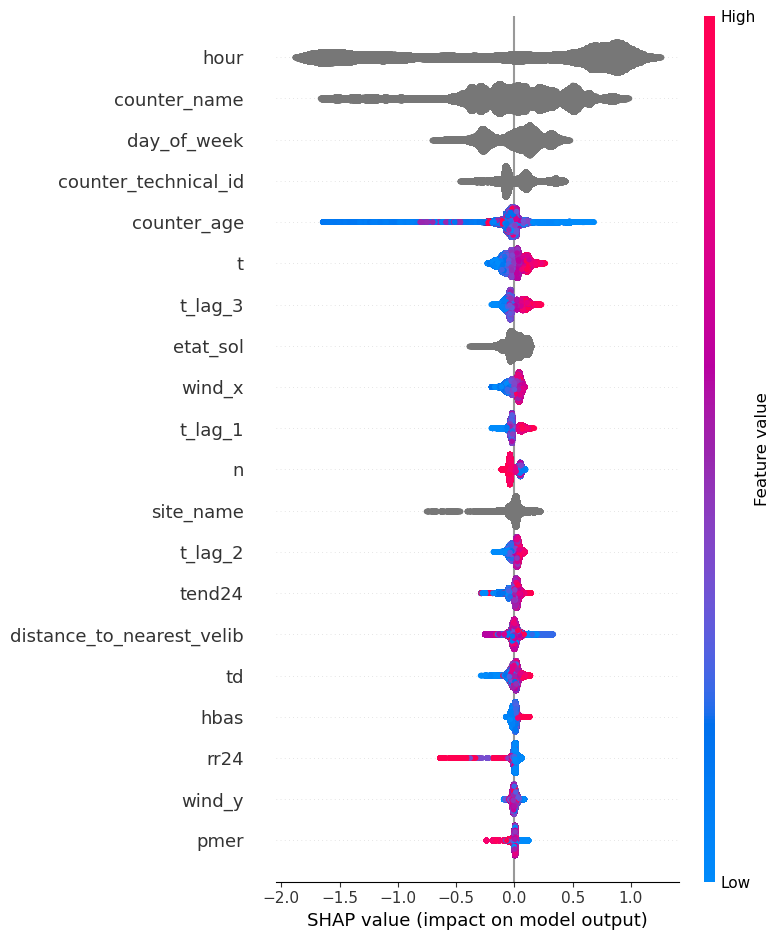

In [166]:
shap.summary_plot(shap_values, X_xgb)

In [173]:
# Assuming you want to analyze the first instance in your dataset
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_xgb.iloc[0, :])

In [176]:
for feature, shap_vals in zip(X_xgb.columns, shap_values):
    print(f"{feature}: Range - ({shap_vals.min()}, {shap_vals.max()})")

counter_age: Range - (-1.8216575671448578, 0.23110565916911965)
t: Range - (-1.7650145776563528, 0.06087986000577717)
t_lag_1: Range - (-1.79632713851564, 0.06572459711177132)
t_lag_2: Range - (-1.7528132103120122, 0.21827107262063097)
t_lag_3: Range - (-1.7019442147601682, 0.5710038522929688)
tend24: Range - (-1.7037642406847273, 0.06135541000532451)
distance_to_nearest_velib: Range - (-1.808000510890966, 0.3148580468965142)
td: Range - (-1.8255118039792917, 0.3111452457935147)
temp_humidity_interaction: Range - (-1.700971341867392, 0.3389995031627332)
wind_x: Range - (-1.7773081589140232, 0.31321537451280257)
wind_y: Range - (-1.6691309393599776, 0.0667616749941822)
tend: Range - (-1.7658381376918606, 0.12227365604423843)
u_lag_1: Range - (-1.7037642406847273, 0.06135541000532451)
u_lag_2: Range - (-1.6813576216471182, 0.06087986000577717)
u_lag_3: Range - (-1.6813576216471182, 0.06087986000577717)
hbas: Range - (-1.680050445113189, 0.05972462320052317)
u: Range - (-1.755354440202867

In [177]:
from sklearn.ensemble import RandomForestRegressor

In [178]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [179]:
preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features_xgb),
        ("standard scaler", numerical_encoder, numerical_features_xgb),
    ]
)

In [180]:
pipeline_rfr = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", rf_model)])

In [181]:
pipeline_rfr.fit(X_xgb, y_xgb)

KeyboardInterrupt: 